Year of order                0
Supplier                     0
Recipient                    2
SIPRI TIV for total order    4
dtype: int64


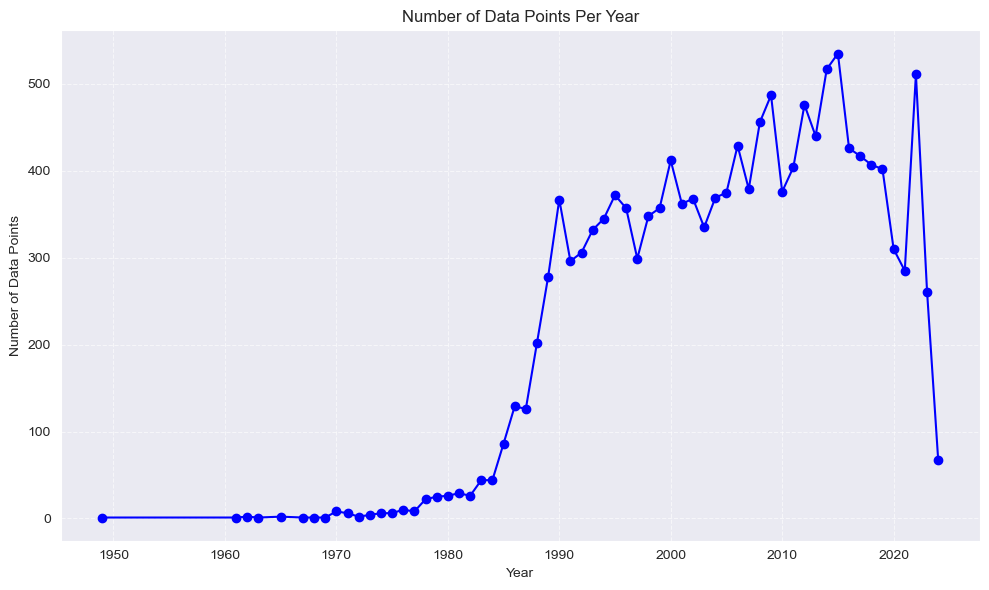

Stable bandwidth of years: 1989.0 to 2022.0


In [356]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# =========================
# 2. Load SIPRI Data and Preprocess
# =========================
# CSV must have columns: year, exporter, importer, tiv
df = pd.read_csv("data/trade-register.csv")
df = df[['Year of order', 'Supplier', 'Recipient', 'SIPRI TIV for total order']]

#handling missing data and negative TIV values
print(df.isna().sum())
df = df.dropna()
df = df[df['SIPRI TIV for total order'] >= 0]

# Count the number of data points per year
data_points_per_year = df.groupby('Year of order').size()

# Plot the number of data points per year
plt.figure(figsize=(10, 6))
plt.plot(data_points_per_year.index, data_points_per_year.values, marker='o', linestyle='-', color='blue')
plt.title('Number of Data Points Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Data Points')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Determine the bandwidth of years where data points are stable
stabilization_threshold = data_points_per_year.max() * 0.5  # Example: 90% of the max value
stable_years = data_points_per_year[data_points_per_year >= stabilization_threshold].index

# Get the start and end of the stable range
start_year = stable_years.min()
end_year = stable_years.max()

print(f"Stable bandwidth of years: {start_year} to {end_year}")





In [357]:
# =========================
# 3. Create Yearly Graphs
# =========================
graphs_by_year = {}
for year, year_df in df.groupby('Year of order'):
    G = nx.DiGraph(year=year)
    for _, row in year_df.iterrows():
        exporter = row['Supplier']
        importer = row['Recipient']
        tiv = row['SIPRI TIV for total order']
        if G.has_edge(exporter, importer):
            G[exporter][importer]['weight'] += tiv
        else:
            G.add_edge(exporter, importer, weight=tiv)
    graphs_by_year[year] = G

# =========================
# 4. Compute Node Features
# =========================
all_features = []
for year, G in graphs_by_year.items():
    for node in G.nodes:
        all_features.append({
            'year': year,
            'country': node,
            'in_degree': G.in_degree(node),
            'out_degree': G.out_degree(node),
            'weighted_in_degree': G.in_degree(node, weight='weight'),
            'weighted_out_degree': G.out_degree(node, weight='weight')
        })

features_df = pd.DataFrame(all_features)

In [358]:
# ===============================
# 5. Build full country–year grid
# ===============================

features_df = (
    features_df
    .set_index(['year', 'country'])
    .reindex(
        pd.MultiIndex.from_product(
            [features_df['year'].unique(),
             features_df['country'].unique()],
            names=['year', 'country']
        )
    )
    .reset_index()
)
# ================================================================
# 6. Rescale years linearly for extra feature in anomaly detection
# ================================================================

features_df['year_scaled'] = MinMaxScaler().fit_transform(features_df[['year']])




In [359]:
# ===================================================================
# 7. Train and fit IsolationForest and LocalOutlierFactor per country
# ===================================================================

feature_cols = [
    'year_scaled',
    'in_degree',
    'out_degree',
    'weighted_in_degree',
    'weighted_out_degree'
]

features_df['iso_anomaly'] = False
features_df['lof_anomaly'] = False

for country, df_c in features_df.groupby('country'):

    df_c = df_c.sort_values('year_scaled')
    df_c = df_c.dropna()
    if len(df_c) < 20:
        continue
    from sklearn.preprocessing import RobustScaler

    X = df_c[feature_cols].values
    transformer = RobustScaler().fit(X)
    X = transformer.transform(X)

    
    # Isolation Forest
    iso = IsolationForest(
        n_estimators=150,
    )
    iso_labels = iso.fit_predict(X)

    # Local Outlier Factor
    lof = LocalOutlierFactor(
        n_neighbors=15,
    )
    
    lof_labels = lof.fit_predict(X)

    # Store results
    features_df.loc[df_c.index, 'iso_anomaly'] = iso_labels == -1
    features_df.loc[df_c.index, 'lof_anomaly'] = lof_labels == -1

In [360]:
####### Nog even goed over nadenken


features_df['anomaly'] = (
    features_df['iso_anomaly'] &
    features_df['lof_anomaly']
)


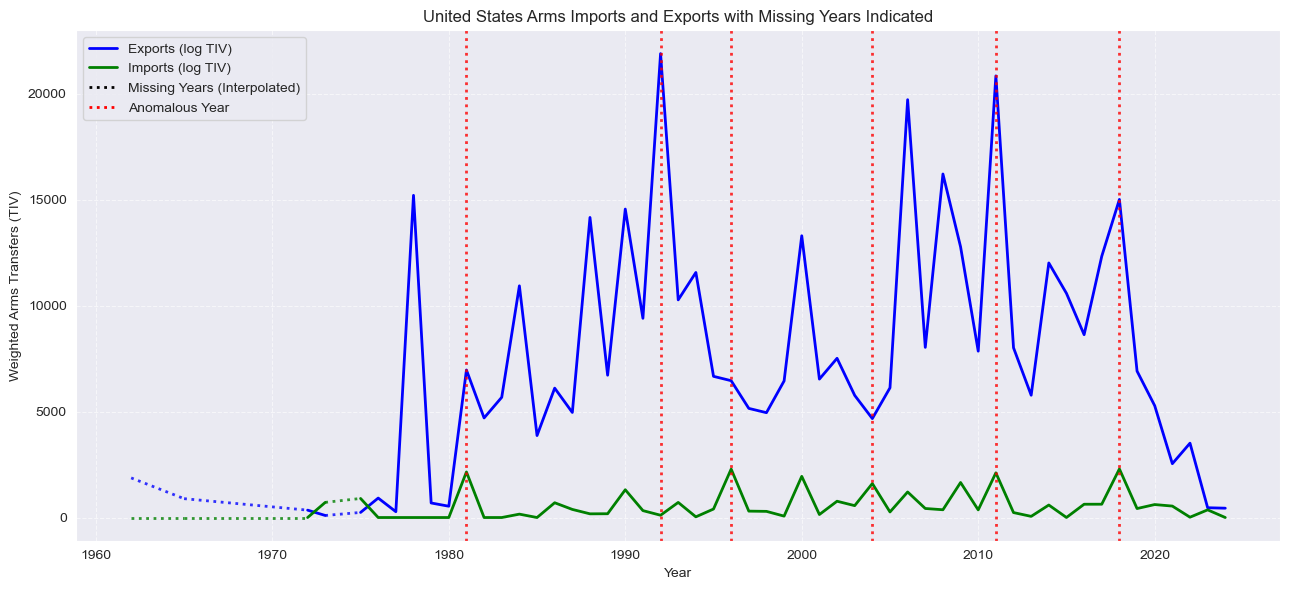

In [368]:
# ===================================================================
# 8. Plot Imports and Exports for a Country with Anomalies Indicated
# ===================================================================
country = 'United States'

country_result_df = (
    features_df[features_df['country'] == country]
    .sort_values('year')
    .set_index('year')
)


full_years = np.arange(country_result_df.index.min(), country_result_df.index.max() + 1)
country_full = country_result_df.reindex(full_years)


plt.figure(figsize=(13, 6))

# Solid lines (actual observed data)
plt.plot(
    country_full.index,
    country_full['weighted_out_degree'],
    color='blue',
    linewidth=2,
    label='Exports (log TIV)'
)

plt.plot(
    country_full.index,
    country_full['weighted_in_degree'],
    color='green',
    linewidth=2,
    label='Imports (log TIV)'
)


# Dotted connectors across missing years
for col, color in [
    ('weighted_out_degree', 'blue'),
    ('weighted_in_degree', 'green')
]:
    y = country_full[col]
    
    valid_idx = np.where(~np.isnan(y.values))[0]

    for i in range(len(valid_idx) - 1):
        idx1 = valid_idx[i]
        idx2 = valid_idx[i + 1]

        if idx2 - idx1 > 1:
            plt.plot(
                [y.index[idx1], y.index[idx2]],
                [y.iloc[idx1], y.iloc[idx2]],
                color=color,
                linestyle=':',
                linewidth=2,
                alpha=0.8
            )



# Anomalous year markers
for year in country_result_df.loc[country_result_df['anomaly'], :].index:
    plt.axvline(
        x=year,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )

# Legend 
missing_line = mlines.Line2D(
    [], [], color='black', linestyle=':', linewidth=2,
    label='Missing Years (Interpolated)'
)

anomaly_line = mlines.Line2D(
    [], [], color='red', linestyle=':', linewidth=2,
    label='Anomalous Year'
)

handles, labels = plt.gca().get_legend_handles_labels()

handles = list(handles) + [missing_line, anomaly_line]

plt.legend(handles=handles)

# Labels and formatting
plt.xlabel('Year')
plt.ylabel('Weighted Arms Transfers (TIV)')
plt.title(f'{country} Arms Imports and Exports with Missing Years Indicated')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


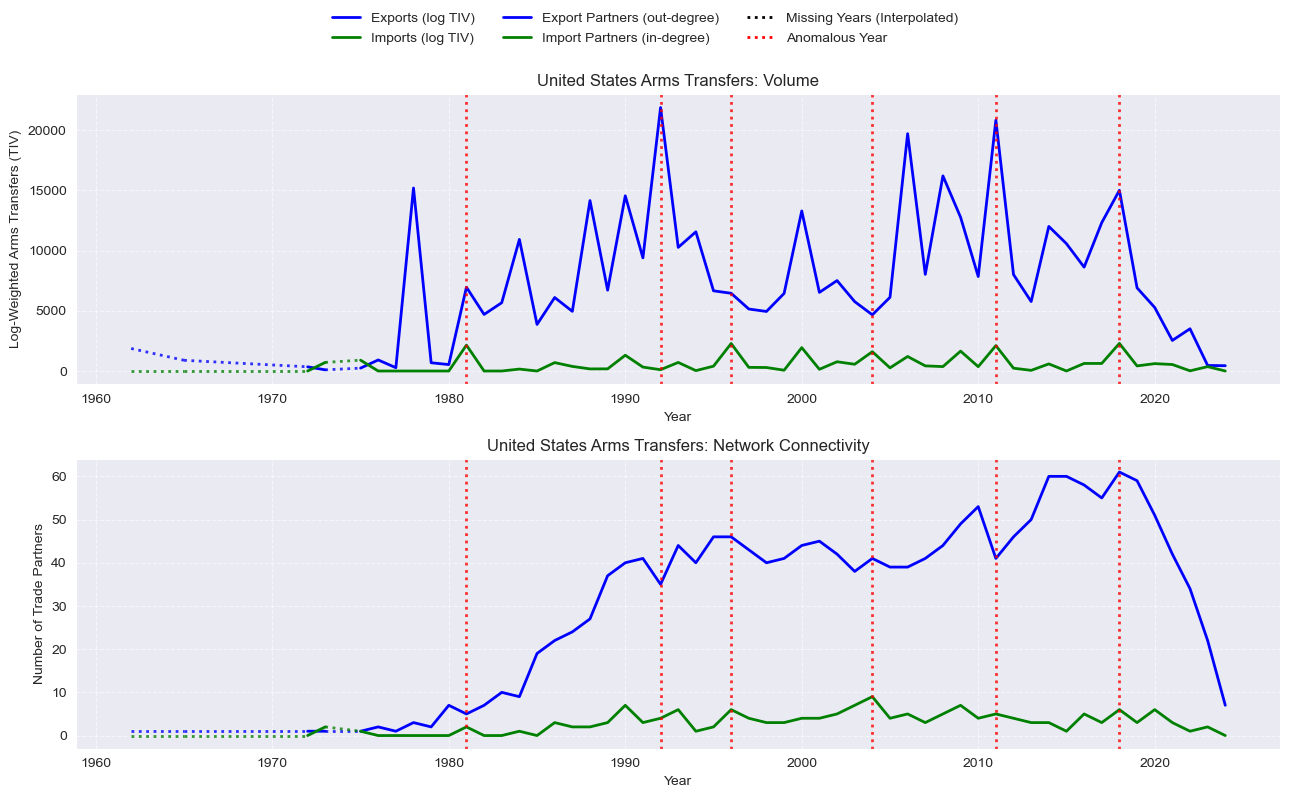

In [369]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# -------------------------------
# Prepare data
# -------------------------------


country_df = (
    features_df[features_df['country'] == country]
    .sort_values('year')
    .set_index('year')
)

# Create full year range to expose missing years
full_years = np.arange(country_df.index.min(), country_df.index.max() + 1)
country_full = country_df.reindex(full_years)

# -------------------------------
# Plot
# -------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(13, 8), sharex=True
)

# =========================================================
# TOP: Weighted volumes
# =========================================================
ax1.plot(
    country_full.index,
    country_full['weighted_out_degree'],
    color='blue',
    linewidth=2,
    label='Exports (log TIV)'
)

ax1.plot(
    country_full.index,
    country_full['weighted_in_degree'],
    color='green',
    linewidth=2,
    label='Imports (log TIV)'
)

# Dotted connectors across missing years
for col, color in [
    ('weighted_out_degree', 'blue'),
    ('weighted_in_degree', 'green')
]:
    y = country_full[col]
    valid_idx = np.where(~np.isnan(y.values))[0]

    for i in range(len(valid_idx) - 1):
        idx1, idx2 = valid_idx[i], valid_idx[i + 1]
        if idx2 - idx1 > 1:
            ax1.plot(
                [y.index[idx1], y.index[idx2]],
                [y.iloc[idx1], y.iloc[idx2]],
                color=color,
                linestyle=':',
                linewidth=2,
                alpha=0.8
            )

# Anomalous year markers
for year in country_df.loc[country_df['anomaly'], :].index:
    ax1.axvline(
        x=year,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )

ax1.set_ylabel('Log-Weighted Arms Transfers (TIV)')
ax1.set_title(f'{country} Arms Transfers: Volume')
ax1.set_xlabel('Year')  # Add a label
ax1.tick_params(axis='x', labelbottom=True)  # Show tick labels
# =========================================================
# BOTTOM: Connectivity (degrees)
# =========================================================
ax2.plot(
    country_full.index,
    country_full['out_degree'],
    color='blue',
    linewidth=2,
    label='Export Partners (out-degree)'
)

ax2.plot(
    country_full.index,
    country_full['in_degree'],
    color='green',
    linewidth=2,
    label='Import Partners (in-degree)'
)

# Dotted connectors across missing years
for col, color in [
    ('out_degree', 'blue'),
    ('in_degree', 'green')
]:
    y = country_full[col]
    valid_idx = np.where(~np.isnan(y.values))[0]

    for i in range(len(valid_idx) - 1):
        idx1, idx2 = valid_idx[i], valid_idx[i + 1]
        if idx2 - idx1 > 1:
            ax2.plot(
                [y.index[idx1], y.index[idx2]],
                [y.iloc[idx1], y.iloc[idx2]],
                color=color,
                linestyle=':',
                linewidth=2,
                alpha=0.8
            )

# Same anomaly markers for alignment
for year in country_df.loc[country_df['anomaly'], :].index:
    ax2.axvline(
        x=year,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )

ax2.set_ylabel('Number of Trade Partners')
ax2.set_xlabel('Year')
ax2.set_title(f'{country} Arms Transfers: Network Connectivity')

# =========================================================
# Legend (shared)
# =========================================================
missing_line = mlines.Line2D(
    [], [], color='black', linestyle=':', linewidth=2,
    label='Missing Years (Interpolated)'
)

anomaly_line = mlines.Line2D(
    [], [], color='red', linestyle=':', linewidth=2,
    label='Anomalous Year'
)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles1 + handles2 + [missing_line, anomaly_line]
labels = labels1 + labels2 + ['Missing Years (Interpolated)', 'Anomalous Year']

fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    ncol=3,
    frameon=False
)

# -------------------------------
# Formatting
# -------------------------------
ax1.grid(True, linestyle='--', alpha=0.6)
ax2.grid(True, linestyle='--', alpha=0.6)

fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
